#Globals

In [1]:
global_var = {
    # Data
    'mesh_data_path' : "/content/mesh_data",
    'mesh_data_url' : "https://drive.google.com/drive/folders/1SRWjFd98IfoWbOm20_RnB90DKem6RYaY?usp=sharing"
}

In [2]:
!pip install gdown open3d --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.9 MB/s eta 0:00:00


#Imports

In [14]:
import gdown
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import os
import plotly.graph_objects as go
import random
import sys
import torch

from torchvision import transforms

In [4]:
if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
    # We try to install PyTorch3D via a released wheel.
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install fvcore iopath
    !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
else:
    # We try to install PyTorch3D from source.
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=19c811b06a4968d0dbd4175902df3696f5ffa093cb8db8f2f0cc1f96f3a26168
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=6eafe6f4681710db283f791aedd7371f0a66f01724a8ce75c2431c05355c9dbd
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 201.1 MB/s eta 0:00:00


In [5]:
from pytorch3d.io import load_objs_as_meshes, load_obj # Util function for loading meshes
from pytorch3d.structures import Meshes # Data structures and functions for rendering
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

In [6]:
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Dataset

## Data download

In [7]:
if not os.path.exists(global_var['mesh_data_path']):
    print("[LOG] Starting dataset download...")
    gdown.download_folder(url = global_var['mesh_data_url'],
        output = global_var['mesh_data_path'],
        quiet=True)
    print("[LOG] Dataset download ended!")

else:
    print("[LOG] Mesh dataset already downloaded!")

[LOG] Starting dataset download...
[LOG] Dataset download ended!


## Shape visualization

In [8]:
def get_dataset_meshes(dataset_path):
    meshes_paths = []
    meshes = []

    for current_dir, _, files in os.walk(dataset_path):
        for elem in files:
            if ".obj" in elem:
                mesh_path = os.path.join(current_dir, elem)
                meshes_paths.append(mesh_path)
                meshes.append(load_objs_as_meshes([mesh_path],device=device))

    return meshes_paths, meshes

In [9]:
def mesh_visualization(obj_file_path):
    mesh = o3d.io.read_triangle_mesh(obj_file_path)

    if mesh.is_empty(): exit()
    if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    colors = None
    if mesh.has_triangle_normals():
        colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
        colors = tuple(map(tuple, colors))
    else:
        colors = (1.0, 0.0, 0.0)

    fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True)
            )
        )
    )

    return fig

In [10]:
meshes_paths, meshes = get_dataset_meshes(global_var['mesh_data_path'])
random_mesh_idx = random.randint(0,len(meshes_paths)-1)
random_mesh_path = meshes_paths[random_mesh_idx]
random_mesh = meshes[random_mesh_idx]

mesh_fig = mesh_visualization(random_mesh_path)
mesh_fig.show()

In [92]:
# selecting mesh for the 2D guidance
guid_mesh_path = meshes_paths[1]
guid_mesh = meshes[1]

mesh_fig = mesh_visualization(guid_mesh_path)
mesh_fig.show()

## Rendered shape visualization

In [11]:
def rendered_shape(mesh, device, items=3):
    distances = [round(random.uniform(1, 3),2) for _ in range(items)] # Controllare valori default da cui selezionare quelli random
    elevations = [random.randint(0, 359) for _ in range(items)] # This is the angle between the vector from the object to the camera, and the horizontal plane y = 0 (xz-plane).
    angles = [random.randint(0, 359) for _ in range(items)] # The vector from the object to the camera is projected onto a horizontal plane y = 0. azim is the angle between the projected vector and a reference vector at (0, 0, 1) on the reference plane (the horizontal plane).
    rendered_images = []

    for idx in range(items):
        print(f"[LOG] Computing render for distance {distances[idx]}, elevation {elevations[idx]}, angle {angles[idx]}")
        R, T = look_at_view_transform(
            distances[idx],
            elevations[idx],
            angles[idx],
            degrees=True)

        cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

        raster_settings = RasterizationSettings(
            image_size=512,
            blur_radius=0.0,
            faces_per_pixel=1,
        )

        lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras,
                raster_settings=raster_settings
            ),
            shader=SoftPhongShader(
                device=device,
                cameras=cameras,
                lights=lights
            )
        )

        rendered_images.append(renderer(mesh))

    return distances, elevations, angles, rendered_images

In [12]:
distances, elevations, angles, rendered_images = rendered_shape(random_mesh,device,items=4)

[LOG] Computing render for distance 1.56, elevation 296, angle 19
[LOG] Computing render for distance 1.44, elevation 336, angle 340
[LOG] Computing render for distance 1.34, elevation 222, angle 215
[LOG] Computing render for distance 2.27, elevation 56, angle 235


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


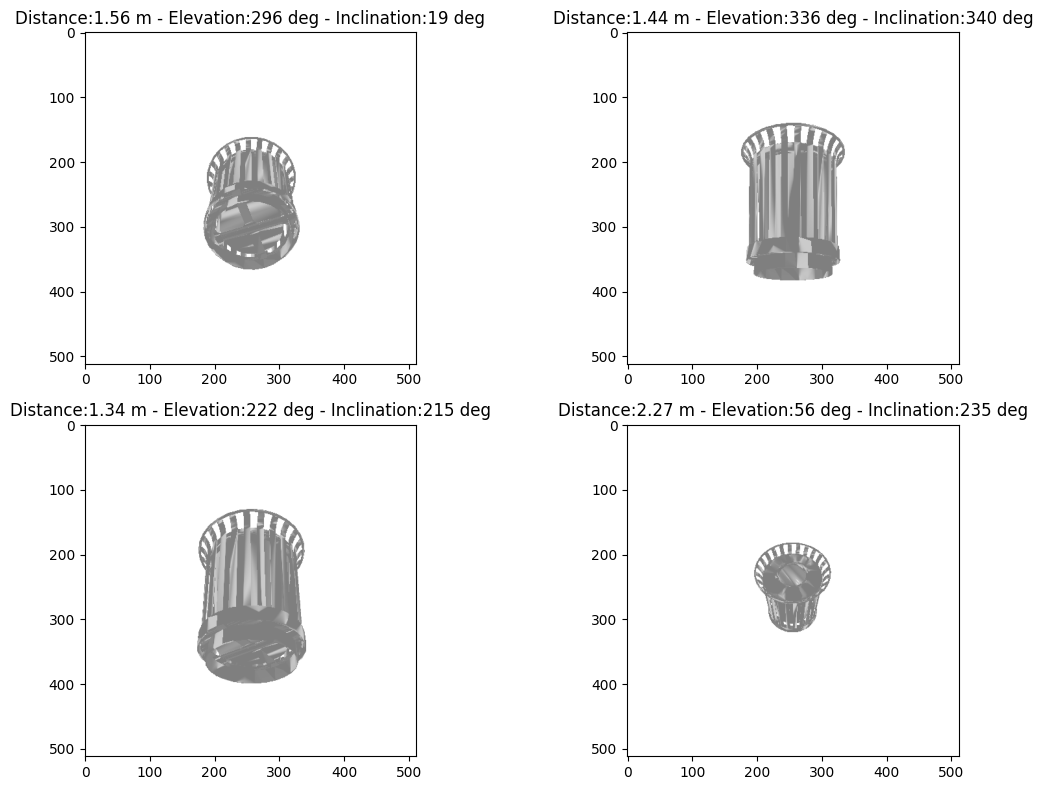

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances[i]} m - Elevation:{elevations[i]} deg - Inclination:{angles[i]} deg")

plt.tight_layout()
plt.show()

## 2D guidance

In [93]:
distances, elevations, angles, rendered_images = rendered_shape(guid_mesh,device,items=4)

[LOG] Computing render for distance 2.34, elevation 27, angle 79
[LOG] Computing render for distance 2.12, elevation 38, angle 6
[LOG] Computing render for distance 2.01, elevation 352, angle 10
[LOG] Computing render for distance 1.83, elevation 186, angle 155


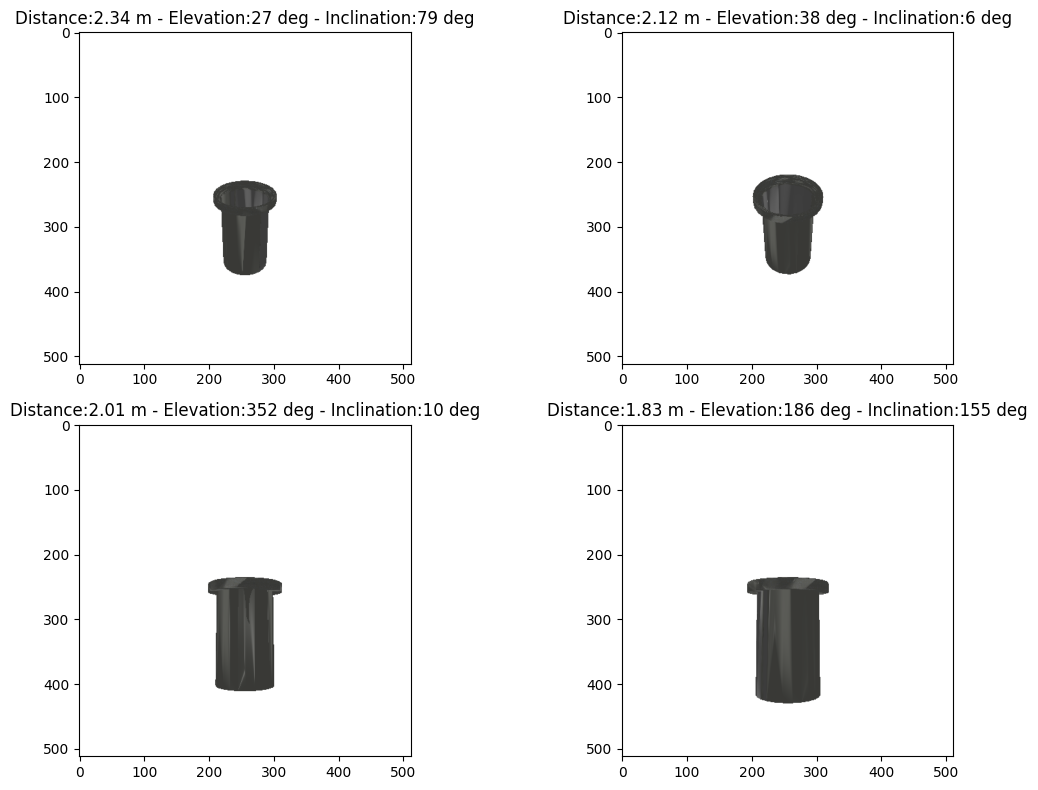

In [94]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

for i, ax in enumerate(ax.flat):
    ax.imshow(rendered_images[i][0, ..., :3].cpu().numpy())
    ax.set_title(f"Distance:{distances[i]} m - Elevation:{elevations[i]} deg - Inclination:{angles[i]} deg")

plt.tight_layout()
plt.show()

In [ ]:
# Questo codice si può sfruttare per ottenere i vertici da passare alla rete neurale
# obj_filename = obj_files[4]
# verts, faces_idx, _ = load_obj(obj_filename)
# faces = faces_idx.verts_idx

# # Initialize each vertex to be white in color.
# verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
# textures = TexturesVertex(verts_features=verts_rgb.to(device))

# # Create a Meshes object
# mesh = Meshes(
#     verts=[verts.to(device)],
#     faces=[faces.to(device)],
#     textures=textures
# )

# # Render the plotly figure
# fig = plot_scene({
#     "subplot1": {
#         "mesh": mesh
#     }
# })
# fig.show()

## 2D augmentation

In [80]:
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(1, 1)),
    transforms.RandomPerspective(fill=1, p=0.8, distortion_scale=0.5)
])

In [81]:
augmented_images = [] # array with augmented images

for rendered_image in rendered_images:
  augmented_image = augment_transform(rendered_image[0, ..., :3].permute(2, 0, 1))
  augmented_images.append(augmented_image)

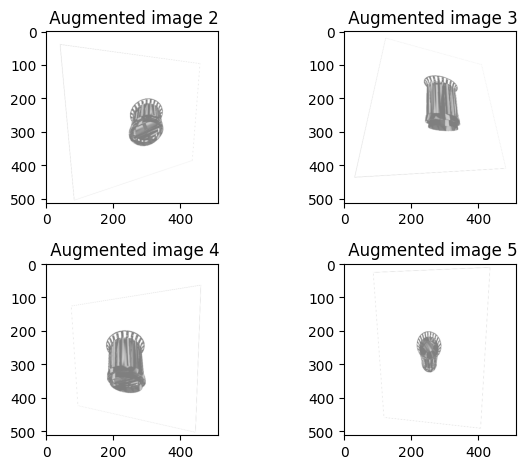

In [82]:
plt.subplot(2, 2, 1)

i  = 0
for augmented_image in augmented_images:
  plt.subplot(2, 2, i + 1)
  i += 1
  plt.imshow(augmented_image.permute(1, 2, 0))  # Convert back to (H, W, C) for display
  plt.title(f" Augmented image {i + 1}")

plt.tight_layout()
plt.show()